Generating 10 synthetic examples...
  Generating example 5/10 (Chunk 0)...
Saving chunk 0 (5 examples) to synthetic_starry_data_part_0.npz...
...Chunk 0 saved.
  Generating example 10/10 (Chunk 1)...

Saving final chunk 1 (5 examples) to synthetic_starry_data_part_1.npz...
...Chunk 1 saved.

...Total generation of 10 examples complete in 32.57 seconds.
Data saved in 2 file(s) with template 'synthetic_starry_data_part_{}.npz'.

Loading and checking the first saved example:
Available keys in loaded file: ['time', 'flux', 'y_coeffs', 'parameters', 'image']

Parameters for the first example:
{'u1': 0.16286313420942028, 'u2': 0.14745268841251324, 'num_spots': 2, 'spots': [{'contrast': 0.6027532694716322, 'radius': 12.620644476176594, 'lat': 0.0, 'lon': -2.5743560948814377}, {'contrast': 0.3881201632308027, 'radius': 13.387216102949566, 'lat': 0.0, 'lon': 76.91172803660655}], 'ro': 0.08927486168017833, 'trajectory': {'xo_start': -1.97391402359777, 'xo_end': 1.9571890875458118, 'yo_const': 0.

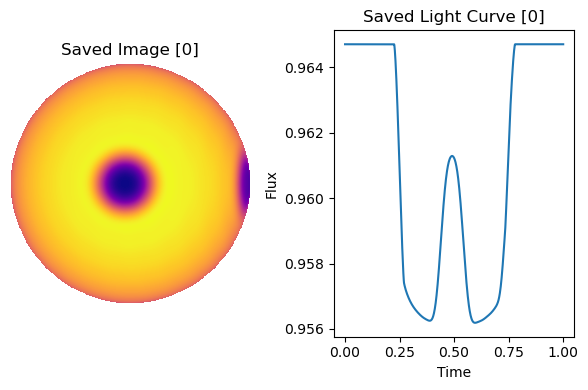

In [ ]:
import starry
import numpy as np
import matplotlib.pyplot as plt # Optional: for checking individual examples
import os
import time as timer # To avoid conflict with starry time variable
import random

# # Optional: Theano configuration (uncomment if needed)
# import theano
# theano.config.gcc__cxxflags += " -fexceptions"

starry.config.lazy = False
starry.config.quiet = True

# --- Generation Parameters ---
# N_EXAMPLES = 10  # Number of examples to generate
# OUTPUT_FILENAME = "synthetic_starry_data.npz"


N_EXAMPLES = 10000
EXAMPLES_PER_FILE = 1000 # Save every 1000 examples
OUTPUT_FILENAME_TEMPLATE = "synthetic_starry_data_part_{}.npz" # Use a template

# --- Parameter Ranges for Random Sampling ---

# Map parameters
YDEG = 30       # Fixed spherical harmonic degree
UDEG = 2        # Fixed limb darkening degree
U1_RANGE = [0.1, 0.3]
U2_RANGE = [0.1, 0.2]

# Spot parameters
NUM_SPOTS_RANGE = [1, 3] # Min and max number of spots
SPOT_CONTRAST_RANGE = [0.2, 0.8] # Relative brightness (lower means darker)
SPOT_RADIUS_RANGE = [3.0, 15.0] # Degrees
SPOT_LAT_RANGE = [0, 0]  # Degrees (-90 to 90 possible, but often constrained)
SPOT_LON_RANGE = [-90.0, 90.0] # Degrees # Make them at least partially visible

# Occultor parameters
RO_RANGE = [0.05, 0.3] # Occultor radius in stellar radii

# Occultor trajectory parameters (defining a linear path)
# xo = np.linspace(xo_start, xo_end, npts)
# yo = constant_yo
XO_START_RANGE = [-2.0, -1.5]
XO_END_RANGE   = [ 1.5,  2.0]
YO_CONST_RANGE = [0,0] # Constant y-offset for the transit
ZO_CONST = 1.0 # Fixed z-distance

# Light curve parameters
N_PTS = 1000 # Number of points in the light curve
TIME_START = 0.0
TIME_END = 1.0

# Rendering parameters (optional, if saving images)
IMG_RESOLUTION = 256 # Pixel resolution for rendered image (lower for speed/size)
SAVE_IMAGES = True   # Set to False if you don't need the rendered images

# --- Generation Function ---

def generate_synthetic_example(param_ranges):
    """
    Generates one synthetic example with randomly sampled parameters.
    """
    params = {}

    # 1. Initialize Map
    map_obj = starry.Map(ydeg=YDEG, udeg=UDEG)

    # 2. Sample and set limb darkening
    u1 = random.uniform(*param_ranges['u1'])
    u2 = random.uniform(*param_ranges['u2'])
    map_obj[1] = u1
    map_obj[2] = u2
    params['u1'] = u1
    params['u2'] = u2

    # 3. Sample and add spots
    num_spots = random.randint(*param_ranges['num_spots'])
    params['num_spots'] = num_spots
    spot_params_list = []
    for i in range(num_spots):
        contrast = random.uniform(*param_ranges['spot_contrast'])
        radius = random.uniform(*param_ranges['spot_radius'])
        lat = random.uniform(*param_ranges['spot_lat'])
        lon = random.uniform(*param_ranges['spot_lon'])
        map_obj.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)
        spot_params_list.append({
            'contrast': contrast,
            'radius': radius,
            'lat': lat,
            'lon': lon
        })
    params['spots'] = spot_params_list # List of dictionaries

    # 4. Get Spherical Harmonic Coefficients
    y_coeffs = map_obj.y # This is the spherical harmonic coefficient vector

    # 5. Render image (optional)
    img_array = None
    if SAVE_IMAGES:
        try:
             # Render at theta=0 (view from positive x-axis)
             # You might want to randomize theta or render multiple views
            img_array = map_obj.render(res=IMG_RESOLUTION, projection='ortho', theta=0.0)
        except Exception as e:
            print(f"Warning: Rendering failed - {e}")
            # Handle cases where rendering might fail (e.g., complex maps)
            img_array = np.full((IMG_RESOLUTION, IMG_RESOLUTION), np.nan) # Placeholder


    # 6. Sample occultor and trajectory parameters
    ro = random.uniform(*param_ranges['ro'])
    xo_start = random.uniform(*param_ranges['xo_start'])
    xo_end = random.uniform(*param_ranges['xo_end'])
    yo_const = random.uniform(*param_ranges['yo_const'])
    zo_const = ZO_CONST # Using the fixed value

    params['ro'] = ro
    params['trajectory'] = {
        'xo_start': xo_start,
        'xo_end': xo_end,
        'yo_const': yo_const,
        'zo_const': zo_const
    }

    # 7. Define time and occultor position arrays
    time_lc = np.linspace(TIME_START, TIME_END, N_PTS)
    xo = np.linspace(xo_start, xo_end, N_PTS)
    yo = np.full(N_PTS, yo_const)
    zo = np.full(N_PTS, zo_const) # zo is fixed in this setup

    # 8. Compute flux (light curve)
    flux = map_obj.flux(xo=xo, yo=yo, ro=ro, zo=zo)

    # 9. Return all generated data
    return time_lc, flux, img_array, y_coeffs, params

# --- Main Generation Loop ---

# Initialize lists to hold data for the current chunk
all_times = []
all_fluxes = []
all_images = []
all_y_coeffs = []
all_params = []

# Define the ranges dictionary to pass to the function
parameter_ranges = {
    'u1': U1_RANGE,
    'u2': U2_RANGE,
    'num_spots': NUM_SPOTS_RANGE,
    'spot_contrast': SPOT_CONTRAST_RANGE,
    'spot_radius': SPOT_RADIUS_RANGE,
    'spot_lat': SPOT_LAT_RANGE,
    'spot_lon': SPOT_LON_RANGE,
    'ro': RO_RANGE,
    'xo_start': XO_START_RANGE,
    'xo_end': XO_END_RANGE,
    'yo_const': YO_CONST_RANGE
}


file_counter = 0
print(f"Generating {N_EXAMPLES} synthetic examples...")
start_time_total = timer.time()

for i in range(N_EXAMPLES):
    # --- Check if it's time to save a chunk ---
    if i > 0 and i % EXAMPLES_PER_FILE == 0:
        current_filename = OUTPUT_FILENAME_TEMPLATE.format(file_counter)
        print(f"\nSaving chunk {file_counter} ({len(all_fluxes)} examples) to {current_filename}...")

        # --- Prepare data dictionary for saving, converting to float32 ---
        save_dict = {
            # Convert lists of arrays to single large arrays with float32 dtype
            'time': np.array(all_times, dtype=np.float32),
            'flux': np.array(all_fluxes, dtype=np.float32),
            'y_coeffs': np.array(all_y_coeffs, dtype=np.float32),
            # Parameters remain as object array
            'parameters': np.array(all_params, dtype=object)
        }
        if SAVE_IMAGES:
            # Handle potential None/NaN images from failed renders before converting
            # If all images are valid ndarrays, convert the whole block to float32
            if all(isinstance(im, np.ndarray) for im in all_images):
                 save_dict['image'] = np.array(all_images, dtype=np.float32)
            else:
                 # If there's a mix (e.g., None or NaN arrays), save as object array
                 # This might lose some compression benefits for images
                 print("Warning: Non-array image detected in chunk. Saving image block as object array.")
                 save_dict['image'] = np.array(all_images, dtype=object)

        # --- Save the chunk ---
        np.savez_compressed(current_filename, **save_dict)
        print(f"...Chunk {file_counter} saved.")

        # --- Reset lists for the next chunk ---
        file_counter += 1
        all_times = []
        all_fluxes = []
        all_images = []
        all_y_coeffs = []
        all_params = []
        # --- End of saving block ---

    # --- Generate one example ---
    # Use end='\r' to keep progress update on the same line
    print(f"  Generating example {i+1}/{N_EXAMPLES} (Chunk {file_counter})...", end='\r')
    time_lc, flux, img, y_coeffs, params = generate_synthetic_example(parameter_ranges)

    # --- Append generated data to the current chunk's lists ---
    # Data is still in its original precision (likely float64) here
    all_times.append(time_lc)
    all_fluxes.append(flux)
    if SAVE_IMAGES:
        all_images.append(img) # Append the raw image (or None/NaN placeholder)
    all_y_coeffs.append(y_coeffs)
    all_params.append(params) # Append the dictionary itself

# --- End of Generation Loop ---
print() # Add a newline after the loop's progress indicator

# --- Save the final (potentially partial) chunk ---
if all_fluxes: # Check if there's any data left in the lists
    current_filename = OUTPUT_FILENAME_TEMPLATE.format(file_counter)
    print(f"\nSaving final chunk {file_counter} ({len(all_fluxes)} examples) to {current_filename}...")

    # --- Prepare data dictionary for saving, converting to float32 ---
    save_dict = {
        'time': np.array(all_times, dtype=np.float32),
        'flux': np.array(all_fluxes, dtype=np.float32),
        'y_coeffs': np.array(all_y_coeffs, dtype=np.float32),
        'parameters': np.array(all_params, dtype=object)
    }
    if SAVE_IMAGES:
        if all(isinstance(im, np.ndarray) for im in all_images):
             save_dict['image'] = np.array(all_images, dtype=np.float32)
        else:
             print("Warning: Non-array image detected in final chunk. Saving image block as object array.")
             save_dict['image'] = np.array(all_images, dtype=object)

    # --- Save the final chunk ---
    np.savez_compressed(current_filename, **save_dict)
    print(f"...Chunk {file_counter} saved.")

end_time_total = timer.time()
print(f"\n...Total generation of {N_EXAMPLES} examples complete in {end_time_total - start_time_total:.2f} seconds.")
print(f"Data saved in {file_counter + 1} file(s) with template '{OUTPUT_FILENAME_TEMPLATE}'.")


# --- Optional: Load and check one example ---
print("\nLoading and checking the first saved example:")
loaded_data = np.load(current_filename, allow_pickle=True) # allow_pickle needed for object array

print("Available keys in loaded file:", list(loaded_data.keys()))

first_time = loaded_data['time'][0]
first_flux = loaded_data['flux'][0]
first_ycoeffs = loaded_data['y_coeffs'][0]
first_params = loaded_data['parameters'][0] # This will be the dictionary

print("\nParameters for the first example:")
print(first_params)

if SAVE_IMAGES and 'image' in loaded_data:
     first_image = loaded_data['image'][0]
     if first_image is not None and not np.all(np.isnan(first_image)):
         plt.figure(figsize=(6, 4))
         plt.subplot(1, 2, 1)
         plt.imshow(first_image, cmap='plasma', origin='lower')
         plt.title("Saved Image [0]")
         plt.axis('off')

         plt.subplot(1, 2, 2)
         plt.plot(first_time, first_flux)
         plt.title("Saved Light Curve [0]")
         plt.xlabel("Time")
         plt.ylabel("Flux")
         plt.tight_layout()
         plt.show()
     else:
          print("First image was not generated or saved properly.")

elif not SAVE_IMAGES:
     plt.figure()
     plt.plot(first_time, first_flux)
     plt.title("Saved Light Curve [0]")
     plt.xlabel("Time")
     plt.ylabel("Flux")
     plt.show()

loaded_data.close() # Good practice to close the file object